In [2]:
# author: Tom Stone <tomstone@stanford.edu>
# author: Proloy Das <email:proloyd94@gmail.com>
# License: BSD (3-clause)
%matplotlib widget
%matplotlib widget
import os
import numpy as np
from scipy import signal, fft
from pathlib import Path

from matplotlib import pyplot
from utils import *

# rcParams are set to make the plots pretty (i.e., publication ready).
pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "figure.constrained_layout.use": True,
    "savefig.dpi": 300      # very imp for publications
})

We will create a random number generator, and seed it (the argument) to make the random number generation reproducible. 
That is, the numbers generarted will be 'random' in the probabilty measure sense, but they will be the same everytime you run the code. 

In [3]:
rng = np.random.default_rng(12345)

## Generating a white noise signal
Create n=1024 time-samples of a Gaussian white noise process.
$$𝔼[𝑤_𝑘]=𝜇$$
$$Var(𝑤_𝑘 )=𝜎^2$$
$$Cov(𝑤_𝑘, 𝑤_𝑙 )=0  \text{ for } 𝑘≠𝑙$$
Assume $\mu = 0$. Hint: use `rng.normal()`

Also create the time indices corresponding the white noise sequence.

In [4]:
wn = rng.normal(size=1024)
time_indices = np.arange(1024)

Plot the white noise againt time using matplotlib.

Text(0.5, 1.0, 'White noise process')

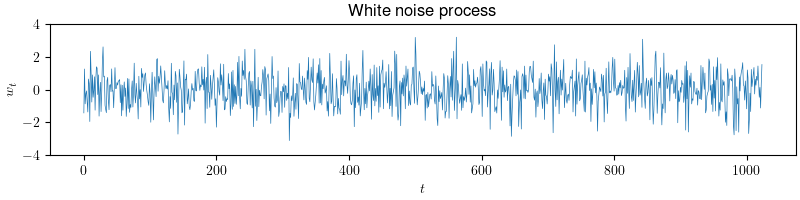

In [5]:
fig1, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(time_indices, wn, linewidth=0.5)
ax.set_xlabel('$t$')
ax.set_ylabel('$w_t$')
ax.set_ylim([-4, 4])
ax.set_title('White noise process')

Now we compute the autocovaraince sequence from the realization that we generated.
$$\hat{s}_k = \frac{1}{N}\sum_{i=1}^{N-\vert k\vert}(x_i-\hat{\mu})(x_{i+\vert k \vert} -\hat{\mu})$$
For that write a funtion with `compute_autocovaraince(signal, max_lag)` that takes in the signal and the maximum lag upto which it needs to compute the autocovaraince sequence as inputs, and returns the autocovaraince, and the associated time indices as output.

Note: This problem can be solved very easily with only a few line of code using `signal.correlate` funtion as instructed bewlow. 

In [6]:
def compute_autocovaraince(x, max_lag=512):
    """Computes autocovarinane upto a given lag.
    
    Parameters:
        x:
            the signal
        max_lag: 
            maximum lag to consider for autocovaraince sequenc
    Returns:
        acov:
            the sample autocovariance, normalized by the number of samples.
        time_indices:
         integer shifts, i.e the x-axis for the autocovariance plot.
    """
    assert max_lag > 0, f"max_lag needs to be >0, received {max_lag}"
    n = wn.shape[-1] # length of time series
    assert max_lag < n, f"max_lag needs to be < signal length ({n}) , received {max_lag}"
    # Compute the mean, `mu`
    mu = x.sum(axis=-1) / n

    # Remove the mean from the sequence
    x = x - mu

    # Use `signal.correlate` function to compute the acov sequence
    # See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html
    # Use mode='full' which returns the full result, i.e. lag -n+1 to lag n-1
    acov = signal.correlate(x, x, mode='full', method='fft') / n
    # Create an index array corrsponding to the correlation values using `numpy.arange``
    indices = np.arange(-n+1, n)

    # Create a boolean selection to extract indices within range[-max_lag, max_lag].
    # Use `numpy.logical_and()`
    selection = np.logical_and(indices < max_lag+1, indices > -max_lag-1)
    return acov[selection], indices[selection]

We will now use the function to compute sample autocovariance sequnce, and compare with the true autocovaraince sequence using a plot.
$$s_k =\begin{cases}
        1 \text{, } k=0 \\
        0 \text{, otherwise}
        \end{cases}$$

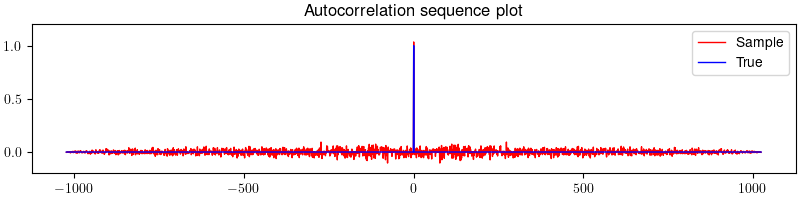

In [7]:
# Sampe autocorrelation
max_lag = wn.shape[-1] - 1
sample_acov, lags = compute_autocovaraince(wn, max_lag)

# True autocovaraince
true_acov = np.zeros_like(sample_acov)
true_acov[max_lag] = 1

fig1, ax = pyplot.subplots(figsize=(8, 2))
ax.plot(lags, sample_acov, linewidth=1, color='r', label='Sample')
ax.plot(lags, true_acov, linewidth=1, color='b', label='True')
ax.set_ylim([-0.2, 1.2])
ax.legend()
_ = ax.set_title('Autocorrelation sequence plot')

Now we are ready to compute the periodogram. Create a function with signature `compute_periodogram(x)` that computes the autocovaraince sequence, and takes its Fourier transform.
$$\hat{S}(f) = T \sum_{-N+1}^{N-1} \hat{s}_k\exp(-i2\pi k fT)$$
The function shall return the power spectral density (PSD) estimate, and associated (normalized) frequency points.

Note: Use `scipy.fft.fft()` function perform the transform.

/var/folders/ml/hxwcm0jd31qgh1t8tjycd7yr0000gq/T/ipykernel_14109/514789528.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(freqs, 10*np.log10(S_xx_est), linewidth=1, color='r', label='Sample')


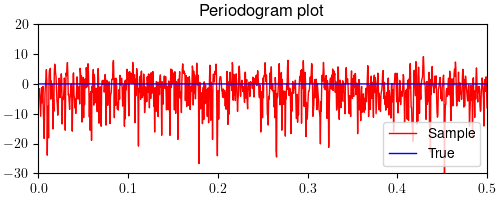

In [8]:
S_xx_est = np.abs(fft.fft(sample_acov))
S_xx_true = np.abs(fft.fft(true_acov))
freqs = np.linspace(0, 1, num=len(lags))

# Periodogram plot
fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(S_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 20])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Periodogram plot')

Now, create a function with signature `compute_periodogram(x)` that uses the following formulae:
$$\hat{S}(f) = \frac{T}{N} \left\vert\sum_{k=0}^{N-1} x_k\exp(-i2\pi k fT)\right\vert^2$$
The function shall return the power spectral density (PSD) estimate, and associated (normalized) frequency points.

Note: Use `scipy.fft.fft()` function perform the transform.

In [9]:
def compute_periodogram(x):
    """Compute periodogram using fft directly on the signal.
    Parameters:
        x:
            the signal
        max_lag: 
            maximum lag to consider for autocovaraince sequenc
    Returns:
        S_xx:
            periodogram.
        freqs:
         associated frequency (normalized) points.
    """
    n = x.shape[-1]
    # Compute the mean
    mu = x.sum() / n
    # remove the mean from the signal
    x = x - mu
    
    # Now use the `fft.fft()` funtion to perform the computation.
    S_xx = np.abs(fft.fft(x)) ** 2 / n
    freqs = np.linspace(0., 1, num=n)
    return S_xx, freqs

Compare the output of the `compute_periodogram()` to the previously computed periodograms. 

In [10]:
S_xx, freqs = compute_periodogram(wn)
ax.plot(freqs, 10*np.log10(S_xx), linewidth=1, color='g', label='True')

# Observations?

1. 
2.
...

We will use the `compute periodogram` function extensively for the rest of the lab.


Before moving further in this notebook, we will take a look at the random processes that are more structured than white noise. 
Lets jump to the AR(2) notebook, and run the same analysis. But, for running same analysis will require us to copy the funtions we just wrote to AR(2) notebook. We will approach this copying a pythonic way. Instead of copying the functions to other notebooks, we will copy them to another python scipt named lab1_utils.py.

You might ask *Why?*. The reason behind this is that once the functions are there, we simply need to import the functions as required, e.g.,
```from lab_utils import compute_autocovariance```
instead of copying the code anymore. 

Less code duplication is your friend for combatting against grave mistakes in data analysis. It makes your analysis managable from one place, thus making mudane code verification work very quick.

# Bias Reduction

We now delve into tapered estimate. As discussed in the class, the aim of tapering is to ensure
$$\mathbb{E}\{\hat{S}(f)\} \approx S(f).$$

Recall the steps for getting tapered estimate:
1. Take a sample of the process $x_0,x_2,⋯,x_(𝑁−1)$.
2. Multiply it by a weighting function (taper), $h_k$, $k = 0, 1, ⋯, 𝑁−1$, that smooths the edges of the date (tapering)
3. Estimate the sample autocovariance based on the tapered data and take the Fourier transform, i.e.,
$$\widehat{S^t}(f) = \frac{T}{N} \left\vert\sum_{k=0}^{N-1} h_kx_k\exp(-i2\pi k fT)\right\vert^2$$
We will follow these steps below. 

But, before that you might ask where do we get the tapers from? 

It turns out that `scipy.signal` got you covered. Check out [https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows). The `scipy.signal.get_window()` function returns window of a given length and type.

We will generate two types tapers: 
1. Hamming: $w(n) = 0.54 - 0.46 \cos\left(\frac{2\pi{n}}{M-1}\right) \qquad 0 \leq n \leq M-1$
2. Hann: $w(n) = 0.5 - 0.5 \cos\left(\frac{2\pi{n}}{M-1}\right) \qquad 0 \leq n \leq M-1$
and visualize them below.

We will also look at their frequency response. Scipy provides `scipy.signal.freqz` as a convenient tool to get the frequency response.

/var/folders/ml/hxwcm0jd31qgh1t8tjycd7yr0000gq/T/ipykernel_14109/2823962835.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = pyplot.subplots(2, 2, figsize=(6, 4))
/var/folders/ml/hxwcm0jd31qgh1t8tjycd7yr0000gq/T/ipykernel_14109/2823962835.py:15: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(freq, 20*np.log10(np.abs(fft_taper)))


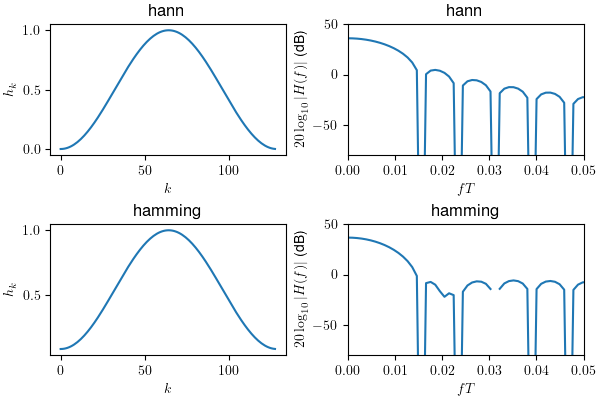

In [28]:
n = 128
windows = dict()
windows['hann'] = signal.get_window('hann', n)
windows['hamming'] = signal.get_window('hamming', n)

figure, axes = pyplot.subplots(2, 2, figsize=(6, 4))
for ax, win_name in zip(axes, windows.keys()):
    taper = windows[win_name]
    ax[0].plot(taper)
    ax[0].set_title(win_name)
    ax[0].set_ylabel('$h_k$')
    ax[0].set_xlabel('$k$')

    freq, fft_taper = signal.freqz(windows[win_name], fs=1)
    ax[1].plot(freq, 20*np.log10(np.abs(fft_taper)))
    ax[1].set_title(win_name)
    ax[1].set_ylabel("$20\log_{10}|H(f)|$ (dB)")
    ax[1].set_xlabel("$fT$")
    ax[1].set_ylim([-80, 50])
    ax[1].set_xlim([0, 0.05])


Any assesments?
Now try `n = 1024` to see what happens.

Now that we know how to generate tapering winows let us write a function `compute_tapered_periodogram(x, window_type)`. 

In [29]:
def compute_tapered_periodogram(x, window_type):    
    """Compute periodogram using after applying given taper

    Parameters:
        x:
            the signal
        window_type: 
            the taper to apply before computing periodogram
    Returns:
        S_xx:
            periodogram.
        freqs:
         associated frequency (normalized) points.
    """
    n = x.shape[-1]
    # generate the taper
    taper = signal.get_window(window_type, n)

    # taper the signal
    tapered_x = x * taper

    # Compute the periodogram using your written `compute_periodogram` function
    # This is 'reuse' of code, and highly encouraged!!!
    St_xx, freqs = compute_periodogram(tapered_x)
    return St_xx, freqs

Lets check if the function works!

In [32]:
St_xx_est, freqs = compute_tapered_periodogram(wn, 'hann')

Then plot it againt the true spectrum.

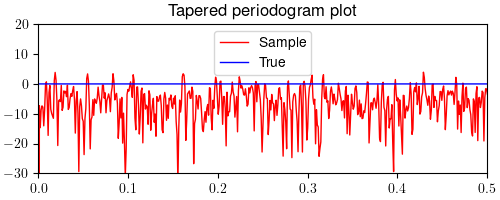

In [35]:
S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 20])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot')

Repeat the same with hamming window.

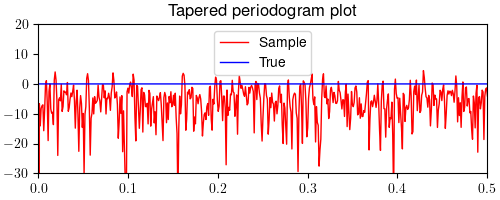

In [37]:
St_xx_est, freqs = compute_tapered_periodogram(wn, 'hamming')

S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 20])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot')

How about the 'best' taper to minimize global bias?
Your function can handle the case if you pass ```window = ('dpss', 4)```, with 4 being the half time-bandwidth product (we shall call it `NW` for the rest of your life).
The effective half bandwidth (normalized) corresponding to this taper is: $$BW = \frac{4}{\text{window length}}$$.

try it out!

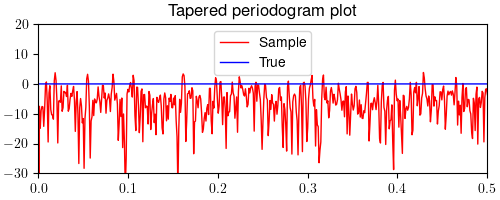

In [39]:
St_xx_est, freqs = compute_tapered_periodogram(wn, ('dpss', 2))

S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(St_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 20])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot')

It worked, right?


Who would knew you can code so efficiently? 😎

Lets also look at the taper to get an idea how the taper looks.

(0.0, 0.05)

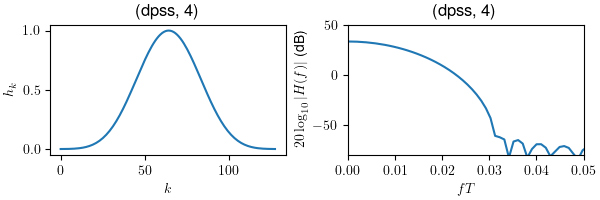

In [50]:
windows['dpss'] = signal.get_window(('dpss', 4), n)

figure, ax = pyplot.subplots(1, 2, figsize=(6, 2))
taper = windows['dpss']
ax[0].plot(taper)
ax[0].set_title('(dpss, 4)')
ax[0].set_ylabel('$h_k$')
ax[0].set_xlabel('$k$')

freq, fft_taper = signal.freqz(windows['dpss'], fs=1)
ax[1].plot(freq, 20*np.log10(np.abs(fft_taper)))
ax[1].set_title('(dpss, 4)')
ax[1].set_ylabel("$20\log_{10}|H(f)|$ (dB)")
ax[1].set_xlabel("$fT$")
ax[1].set_ylim([-80, 50])
ax[1].set_xlim([0, 0.05])

What's the effective bandwidth, guys? [Fill in the gaps between two curly braces!]

In [51]:
print(f"The effective bandwidth is {4/n}")

0.03125

Can you see that bandwidth in the upper plot?

Now you know the drill. We will copy the function to the `utils.py`, and you are gonna get the tapered periodogram estimate for the other two cases.

# Variance Reduction

As wer learned in the class, the way to do variance reduction is get multiple **uncorrleated** samples of the same process, and average them. We will use the dpss sequences to achieve multiple **uncorrleated** samples of the spectrum estimate, and average them to get what we call multitaper estimate.

But, first lets look at higher order dpss sequences. (So far we only saw the 0th order one) 
The `scipy.signal.get_window()` funtion accepts a keyword `Kmax` that controls the number of dpss tapers returned. 

Verify from the documentation. [https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.dpss.html#scipy.signal.windows.dpss](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.dpss.html#scipy.signal.windows.dpss)

In [64]:
NW = 4
dpss_win = signal.windows.dpss(n, NW, Kmax=7)

Now, visulalize them.

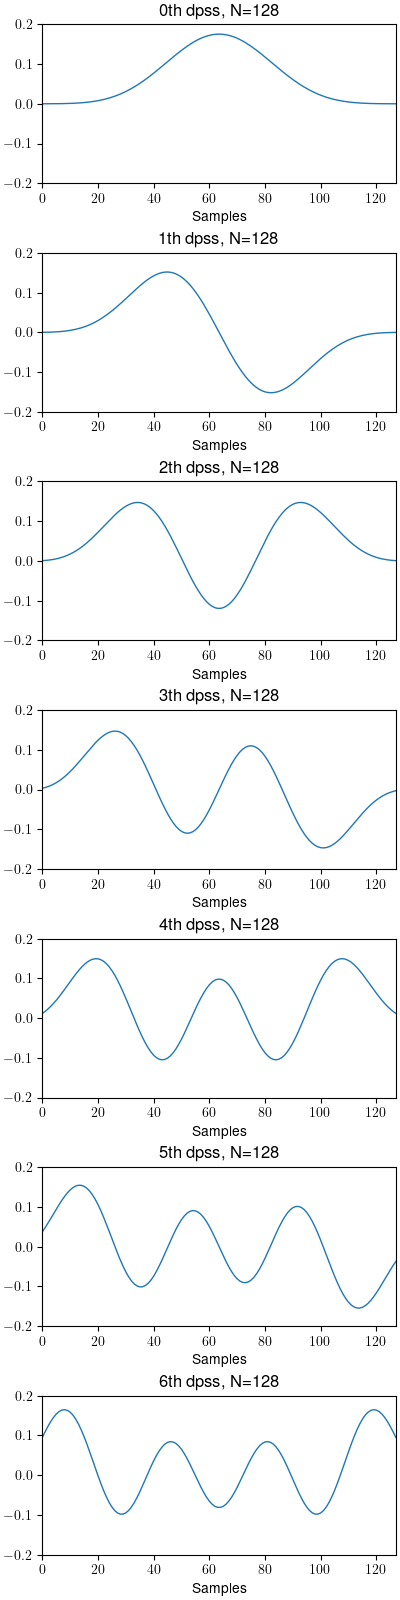

In [78]:
fig, axes = pyplot.subplots(len(dpss_win), 1, figsize=(4, 16))
for i, (ax, win) in enumerate(zip(axes, dpss_win)):
    ax.plot(win, linewidth=1.)
    ax.set(xlim=[0, n-1], ylim=[-0.2, 0.2], xlabel='Samples',
        title=f'{i}th dpss, N={n}')

Now, write a function `compute_multitaper_spectrum()` for forming multitaper spectral estimate from a given data, time-bandwidth product (NW) and number of tapers to use. For this you need to 
1. get the tapers using the data length, time-bandwidth product (NW) and number of tapers.
2. form the tapered estimates.
3. combine them to get the multitaper sepctrum estimate.
 
We will have to pay attention to the taper generation because of existence different normalization procedures. See the `norm` parameter in the `dpss` documentation. We suggest to use `norm=2`, that way the tapers come normalized by l2-norm, and also by window length. So, you will have to take special care of that. That is, with these tapers, $h_k$ the tapered estimate is given by:
$$\widehat{S^t}(f) = T \left\vert\sum_{k=0}^{N-1} h_kx_k\exp(-i2\pi k fT)\right\vert^2$$


In [120]:
def compute_multitaper_spectrum(x, NW, Kmax):
    """Compute multitaper spectrum with Kmax tapers of NW 
    time-bandwidth product

    Parameters:
        x:
            the signal
        NW: 
            time-bandwidth product
        Kmax:
            Number of tapers to use
    Returns:
        S_xx:
            periodogram.
        freqs:
         associated frequency (normalized) points.
    """
    n = x.shape[-1]
    # generate the tapers, use norm=2 keyword
    dpss_tapers = signal.windows.dpss(n, NW, Kmax=Kmax, norm=2)
    # These tapers are normalized by window length, so you need to take care of them.

    # Cycle through the tapers in a for loop, and get the tapered estimate
    # Store the generate estimates in a list.
    St_xxs = []
    for taper in dpss_tapers:
        # taper the signal
        tapered_x = x * taper

        # Compute the periodogram using your written `compute_periodogram` function
        # This is 'reuse' of code, and highly encouraged!!!
        St_xx, freqs = compute_periodogram(tapered_x)
        St_xxs.append(St_xx * n)
    # We will stack the rows in the list vertically to create a numpy array
    St_xxs = np.vstack(St_xxs)
    # Then take its mean in first (0th) dimension to get the multitaper estimate
    Smtm_xx = St_xxs.mean(0)
    return Smtm_xx, freqs

In [122]:
Smtm_xx_est, freqs = compute_multitaper_spectrum(wn, NW=4, Kmax=6)

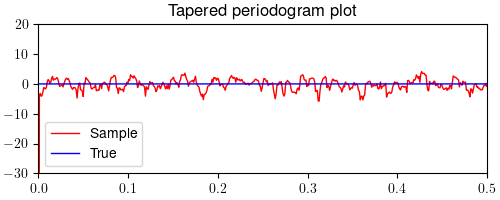

In [123]:
S_xx_true = np.abs(fft.fft(true_acov))
freqs_ = np.linspace(0, 1, num=len(S_xx_true))

fig1, ax = pyplot.subplots(figsize=(5, 2))
ax.plot(freqs, 10*np.log10(Smtm_xx_est), linewidth=1, color='r', label='Sample')
ax.plot(freqs_, 10*np.log10(S_xx_true), linewidth=1, color='b', label='True')
ax.set_ylim([-30, 20])
ax.set_xlim([0., 0.5])
ax.legend()
_ = ax.set_title('Tapered periodogram plot')